# GOES16 Pipeline


> In this tutorial, we will walk through how one can download data and prep for any further machine learning work with the GOES16 dataset.
> We will:
> 1) download the data
> 2) harmonize the data
> 3) create patches that are ready for ML consumption.

In [1]:
import autoroot
import os
from dotenv import load_dotenv
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
xr.set_options(
    keep_attrs=True, 
    display_expand_data=False, 
    display_expand_coords=False, 
    display_expand_data_vars=False, 
    display_expand_indexes=False
)
np.set_printoptions(threshold=10, edgeitems=2)

import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=1.0)

%matplotlib inline

***

## Download

Firstly, we need to download the data.

#### Save Directory

This is arguably the most important part.
We need to define where we want to save the data.

We use the `autoroot` package to manually handle all of the 


In [2]:
root_dir = autoroot.root

**Note**: The data is very heavy! So make sure you have adequate space.

In [3]:
save_dir = os.getenv("ITI_DATA_SAVEDIR")

#### Config

We have a configuration file which features some of the options available for downloading data.
One can take a peek using the command below.

In [4]:
!cat $autoroot.root/config/example/download.yaml

# PERIOD
period:
  start_date: '2020-10-01'
  start_time: '00:00:00'
  end_date: '2020-10-31'
  end_time: '23:59:00'

# CLOUD MASK
cloud_mask: True
  
# PATH FOR SAVING DATA
save_dir: data

defaults:
  - _self_
  


We also have some more things we can change that are satellite specific.

We can see them using the command below.

In [5]:
# !cat $autoroot.root/config/example/satellite/goes.yaml


```yaml
download:
  _target_: rs_tools._src.data.goes.downloader_goes16.download
  save_dir: ${save_dir}/goes16/raw
  start_date: ${period.start_date}
  start_time: ${period.start_time}
  end_date: ${period.end_date}
  end_time: ${period.end_time}
  daily_window_t0: "14:00:00"
  daily_window_t1: "20:00:00"
  time_step: "1:00:00"
```

For this tutorial, we will change the save directory, start/end time, and the time step.

Notice how we will change some configurations within the `download.yaml` file and some others that are within the `satellite.yaml` file, in particular the `goes.yaml`.

```bash
python rs_tools \
    satellite=goes \
    stage=download \
    save_dir="/path/to/savedir" \
    period.start_date="2020-10-01" \
    period.end_date="2020-10-02" \
    period.start_time="09:00:00" \
    period.end_time="21:00:00" \
    satellite.download.time_step="6:00:00"
```

***

## GeoProcessing


We have an extensive geoprocessing steps to be able to 

We can peek into the `rs_tools/config/example/download.yaml` configuration file to see some of the options we have to modify this.


In [6]:
!cat $autoroot.root/config/example/satellite/goes.yaml

download:
  _target_: rs_tools._src.data.goes.downloader_goes16.download
  save_dir: ${save_dir}/goes16/raw
  start_date: ${period.start_date}
  start_time: ${period.start_time}
  end_date: ${period.end_date}
  end_time: ${period.end_time}
  daily_window_t0: "14:00:00"
  daily_window_t1: "20:00:00"
  time_step: "1:00:00"

geoprocess:
  _target_: rs_tools._src.geoprocessing.goes.geoprocessor_goes16.geoprocess
  read_path: ${read_path}/goes16/raw
  save_path: ${save_path}/goes16/geoprocessed
  resolution: null
  region: "-130 -15 -90 5"
  resample_method: bilinear

# preprocess:

patch:
  _target_: rs_tools._src.preprocessing.prepatcher.prepatch
  read_path: ${read_path}/goes16/geoprocessed
  save_path: ${save_path}/goes16/analysis
  patch_size: ${patch_size}
  stride_size: ${stride_size}
  nan_cutoff: ${nan_cutoff}
  save_filetype: ${save_filetype}


In particular, we will focus on the `geoprocess` step within the configuration.
The most important options are the `resolution` and the `region`.
The resolution is a float or integer that is measured in km.

Below, we have an example of the command we 

```bash
python rs_tools \
    satellite=goes \
    stage=geoprocess \
    read_path="/path/to/savedir/" \
    save_path="/path/to/savedir/" \
    satellite.geoprocess.resolution=5000
```

We can see the saved data are clean

```bash
/path/to/savedir/goes16/geoprocessed/20201001150019_goes16.nc
/path/to/savedir/goes16/geoprocessed/20201002150019_goes16.nc
```

In [7]:
ds = xr.open_dataset(f"{save_dir}/goes16/geoprocessed/20201001150019_goes16.nc", engine="netcdf4")

ds

<xarray.Dataset> Size: 10MB
Dimensions:          (x: 302, y: 207, time: 1, band_wavelength: 16, band: 16)
Coordinates: (8)
Data variables: (2)
Attributes: (12/30)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    production_site:           RBU
    ...                        ...
    timeline_id:               ABI Mode 6
    date_created:              2020-10-01T15:09:56.5Z
    time_coverage_start:       2020-10-01T15:00:19.6Z
    time_coverage_end:         2020-10-01T15:09:50.4Z
    LUT_Filenames:             SpaceLookParams(FM1A_CDRL79RevP_PR_09_00_02)-6...
    id:                        ae981973-758f-4213-b71e-e619d91ddddb

### Demo Visualization

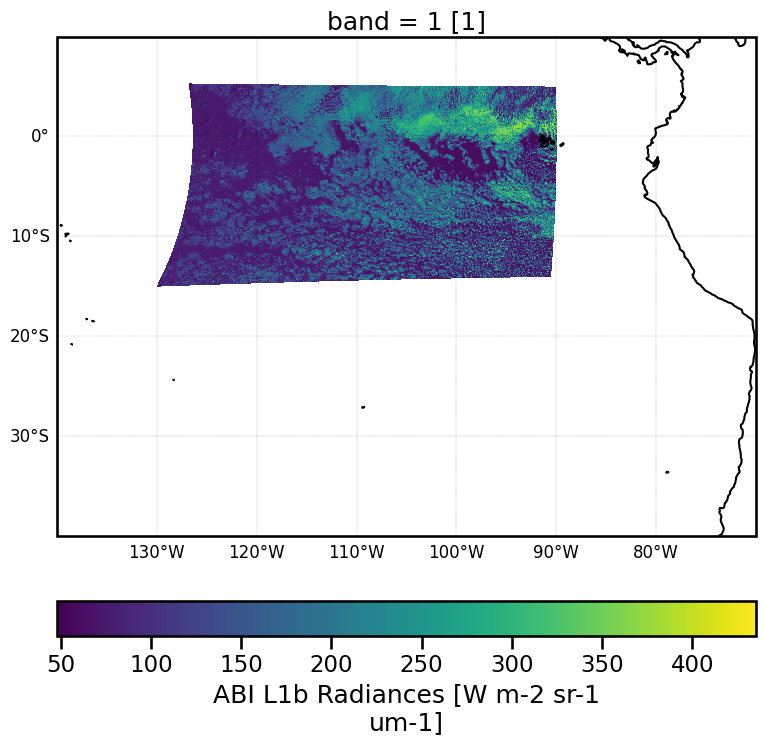

In [8]:
# in an even better way 
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
cbar_kwargs = {
    "fraction": 0.06, 
    "pad": 0.1, 
    "orientation": "horizontal",
}
# ax.set_extent([-20, -10, 30, 60])
# out["1"].plot(ax=ax, transform=ccrs.PlateCarree())
# ax.pcolormesh(out["1"].longitude, out["1"].latitude, out["1"].values)
ds.isel(band=0).Rad.plot.pcolormesh(
    x="longitude", y="latitude", transform=ccrs.PlateCarree(),
    cbar_kwargs=cbar_kwargs
)


ax.set(xlim=[-140, -70,],
      ylim=[ -40, 10])

# # Add map features with Cartopy 
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                             edgecolor='face', 
#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12} 
plt.tight_layout()
plt.show()

## Patching

In [9]:
!cat $root_dir/config/example/patch.yaml

# PATH WITH GEOPROCESSED DATA
read_path: data

# PATH FOR SAVING PATCHES
save_path: data

# PATCH PARAMETERS
patch_size: 256
stride_size: 256

# NAN CUTOFF
nan_cutoff: 0.5

# FILETYPE TO SAVE [nc = netcdf, np = numpy]
save_filetype: nc

defaults:
  - _self_

The most important arguments are the `patch_size` and `stride_size` argument.
The *patch_size* dictates how big the patches should be and the *stride_size* dictates how much space should be between patches. 
For complete overlap, the stride size should be the `patch_size-1`.
For no overlap, the stride size should be `patch_size`

```bash
python rs_tools satellite=goes stage=patch read_path=$save_dir save_path=$save_dir nan_cutoff=0.5 
patch_size=16 stride_size=16
```

#### Demo Visualization

In [10]:
ds = xr.open_dataset(f"{save_dir}/goes16/analysis/20201001150019_patch_0.nc", engine="netcdf4")

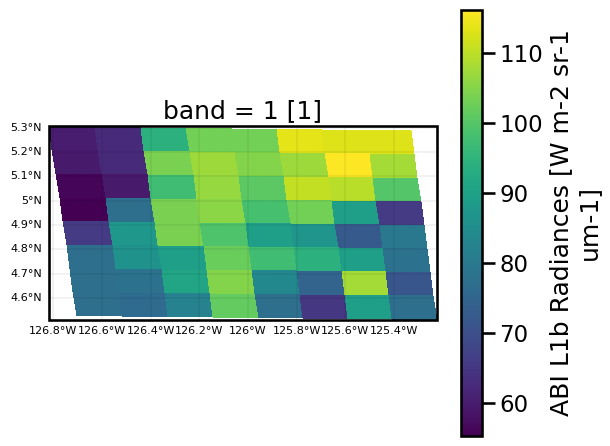

In [11]:
# in an even better way 
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-20, -10, 30, 60])
# out["1"].plot(ax=ax, transform=ccrs.PlateCarree())
# ax.pcolormesh(out["1"].longitude, out["1"].latitude, out["1"].values)
ds.isel(band=0).Rad.plot.pcolormesh(x="longitude", y="latitude", transform=ccrs.PlateCarree())


# ax.set(xlim=[-140, -70,],
#       ylim=[ -40, 10])

# # Add map features with Cartopy 
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                             edgecolor='face', 
#                                             facecolor='lightgray'))
ax.coastlines()
# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.1, color='k', alpha=1, 
                  linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 
plt.tight_layout()
plt.show()

## DataLoading

We can start using any dataloader framework right away.
In this example, we will use PyTorch.

In [12]:
from rs_tools._src.utils.io import get_list_filenames
from rs_tools._src.datamodule.utils import load_nc_file
from rs_tools._src.datamodule.editor import StackDictEditor, CoordNormEditor
from toolz import compose_left

/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
/home/juanjohn/miniconda/envs/rs_tools/lib/python3.11/site-packages/goes2go/NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),


We will create a very simple demo dataloader

In [13]:
from torch.utils.data import Dataset, DataLoader
from typing import Optional, Callable

class NCDataReader(Dataset):
    def __init__(self, data_dir: str, ext: str=".nc", transforms: Optional[Callable]=None):
        self.data_dir = data_dir
        self.data_filenames = get_list_filenames(data_dir, ext)
        self.transforms = transforms

    def __getitem__(self, ind) -> np.ndarray:
        nc_path = self.data_filenames[ind]
        x = load_nc_file(nc_path)
        if self.transforms is not None:
            x = self.transforms(x)
        return x

    def __len__(self):
        return len(self.data_filenames)

In [14]:
ds = NCDataReader(f"{save_dir}/goes16/analysis")
dl = DataLoader(ds, batch_size=8)

In [15]:
out = next(iter(dl))

In [16]:
list(out.keys())

['data', 'wavelengths', 'coords', 'cloud_mask']

In [17]:
out["data"].shape, out["coords"].shape

(torch.Size([8, 16, 8, 8]), torch.Size([8, 2, 8, 8]))

### Transforms/Editors

We can also use custom transformations within the dataset (just like standard PyTorch) to transform our dataset

In [18]:
transforms = compose_left(
    CoordNormEditor(), 
    StackDictEditor(),
)

In [19]:
# initialize dataset with transforms
ds = NCDataReader(f"{save_dir}/goes16/analysis", transforms=transforms)

# initialize dataloader
dl = DataLoader(ds, batch_size=8)

# do one iteration
out = next(iter(dl))

# inspect a batch
out.shape

torch.Size([8, 19, 8, 8])